<a href="https://colab.research.google.com/github/arkeodev/XAI/blob/main/Layerwise_Relevance_Propagation_(LRP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Layerwise Relevance Propagation (LRP)

LRP is a technique used to explain the predictions of complex models by tracing the prediction back through the layers of the network to the input features, thereby providing a visual map or a set of influential features that led to the decision.

LRP has a theoretical foundation in Taylor decomposition, which helps explain the contributions of individual components (input features) to a function's (network's) output near a point (the input data).

<figure>
    <img src="https://raw.githubusercontent.com/arkeodev/XAI/main/images/lrp.png" width="800" height="300" alt="LRP">
    <figcaption>LRP</figcaption>
</figure>

# Mathematical Foundation

The Layer-wise Relevance Propagation (LRP) algorithm elucidates the decisions of neural network models by highlighting the input features that contribute to the prediction.

At its core, LRP operates by tracing the prediction backward, redistributing the prediction onto the relevant neurons layer by layer in the network.

Below, we dissect the mathematics underpinning LRP and its propagation rules, establishing the foundation for its implementation and application.

### Propagation Rules

LRP begins with the prediction output of the network and backpropagates this 'relevance' score to the input features. The mathematical formulation for this process uses the following propagation rule for a neuron *j* in one layer to neurons *k* in the subsequent layer:

$$
R_j = \sum_{k} \left( \frac{z_{jk}}{\sum_j z_{jk}} \right) R_k
$$

where $( z_{jk} )$ represents the contribution of neuron $( j )$ to the activation of neuron *k*. The relevance scores $( R_k )$ are distributed backwards to neuron *j* ensuring that the total relevance remains conserved throughout the layers.

In [1]:
import numpy as np

def lrp_propagate(relevances_upper_layer, contributions_z_jk):
    """
    Propagates relevance scores from an upper layer to a lower layer using the LRP rule.

    Parameters:
    - relevances_upper_layer: numpy array of relevance scores for the upper layer neurons.
    - contributions_z_jk: numpy 2D array where each element z_jk represents the
      contribution of lower layer neuron j to the activation of upper layer neuron k.

    Returns:
    - relevances_lower_layer: numpy array of computed relevance scores for the lower layer neurons.
    """
    # Compute the sum of contributions for each upper layer neuron
    sum_z_jk = np.sum(contributions_z_jk, axis=0, keepdims=True)

    # Compute the relevance for each lower layer neuron
    relevances_lower_layer = np.sum((contributions_z_jk / sum_z_jk) * relevances_upper_layer, axis=1)

    return relevances_lower_layer

# Suppose we have 3 neurons in the lower layer and 2 neurons in the upper layer
relevances_upper_layer = np.array([1.2, 0.8])  # relevance scores for the upper layer
contributions_z_jk = np.array([[0.5, 0.2], [0.3, 0.4], [0.2, 0.4]])  # contributions from lower layer to upper layer

# Propagate the relevance scores to the lower layer
relevances_lower_layer = lrp_propagate(relevances_upper_layer, contributions_z_jk)
print(relevances_lower_layer)

[0.76 0.68 0.56]


### Conservation Property

A key aspect of LRP is its conservation property, which ensures that the sum of relevance scores is preserved across layers. Mathematically, this can be expressed as:

$$
\sum_j R_j = \sum_k R_k
$$

which implies that the total relevance at any layer is equal to the total relevance of the preceding layer, eventually equating to the function output $( f(x) )$.

In [2]:
# For the above calculation shows the conversation property
import numpy as np

def check_conservation(relevances_upper_layer, relevances_lower_layer):
    """
    Checks if the sum of relevance scores is preserved from the upper layer to the lower layer.

    Parameters:
    - relevances_upper_layer: numpy array of relevance scores for the upper layer neurons.
    - relevances_lower_layer: numpy array of relevance scores for the lower layer neurons.

    Returns:
    - Boolean indicating if the conservation property is satisfied.
    """
    return np.isclose(np.sum(relevances_upper_layer), np.sum(relevances_lower_layer))

# Check if the conservation property holds
conservation_holds = check_conservation(relevances_upper_layer, relevances_lower_layer)
print(f"Conservation Property Holds: {conservation_holds}")
print(f"Sum of Relevances in Upper Layer: {np.sum(relevances_upper_layer)}")
print(f"Sum of Relevances in Lower Layer: {np.sum(relevances_lower_layer)}")


Conservation Property Holds: True

Sum of Relevances in Upper Layer: 2.0

Sum of Relevances in Lower Layer: 2.0


### Deep Taylor Decomposition

LRP can be theoretically justified through the Deep Taylor Decomposition, where the backpropagation of relevance is considered a series of Taylor expansions at each neuron. This perspective allows us to model complex non-linear relationships within the network.

The Deep Taylor Decomposition provides a theoretical foundation for LRP by allowing for the approximation of complex, non-linear neural network behaviors with simpler, locally linear functions. This enables a principled way to dissect the network's decision-making process, revealing which input features are most relevant for a given prediction.

#### Conceptual Overview

Suppose we have a neural network that makes predictions based on some input features. The prediction could be anything such as whether an image contains a cat. The final output of this network is a complex, non-linear function of the input. LRP aims to explain this prediction by distributing the "relevance" of the prediction back through the network to the input features.

Deep Taylor Decomposition aids in this process by simplifying how we understand each neuron's contribution to the prediction. Essentially, it breaks down the complex, non-linear relationships into series of locally linear approximations.

#### Simplified Example

Imagine a very simple neural network with one hidden layer that predicts whether an image contains a cat, based on two features: $(x_1)$ (shape) and $(x_2)$ (color). The final output, $(f(x))$, is the prediction score of the image being a cat.

For a specific prediction, say $(f(x) = 0.8)$, indicating a high confidence that the image contains a cat, we want to understand which feature contributed more to this decision.

#### Step 1: Taylor Expansion at a Neuron

Let's focus on a neuron in the hidden layer that receives $(x_1)$ and $(x_2)$. Suppose this neuron significantly activates for cat-like shapes but is indifferent to color. At this neuron, we perform a Taylor expansion centered at a reference point (e.g., where $(x_1)$ is a non-cat-like shape, and $(x_2)$ has a neutral color).

The first-order Taylor expansion of the neuron's activation might look something like this:

$$
f(x) \approx f(a) + (x_1 - a_1)f'(a_1) + (x_2 - a_2)f'(a_2)
$$

where $(a)$ is the reference point, and $(f')$ represents the partial derivatives of the neuron's activation function with respect to $(x_1)$ and $(x_2)$.

#### Step 2: Distributing Relevance

Using DTD, we interpret the terms $((x_1 - a_1)f'(a_1))$ and $((x_2 - a_2)f'(a_2))$ as the contributions of $(x_1)$ and $(x_2)$ to the activation of this neuron. Because our neuron is primarily sensitive to shape $(x_1)$, the contribution from $(x_1)$ will be larger.

In the context of LRP, these contributions are considered "relevance" scores that are backpropagated to the input features. The relevance score associated with $(x_1)$ would be higher, indicating that shape is more important for this prediction.


#### Deep Taylor Decomposition

The process described simplifies complex functions into locally linear ones, making it easier to distribute relevance scores back to the input features. By performing similar decompositions at each neuron across the network, LRP can trace back the prediction's relevance to the original input features, despite the network's non-linear complexities.

### LRP Rules for Deep Rectifier Networks

Rectifier networks, particularly those with ReLU activations, are ubiquitous in modern deep learning applications. For such networks, different LRP rules apply:


#### Basic Rule (LRP-0)

The Basic Rule of Layer-wise Relevance Propagation (LRP-0) suggests distributing the relevance scores to input features proportionally to their contribution to neuron activations:

$$
R_j = \sum_{k} \left( \frac{a_j w_{jk}}{\sum_{j} a_j w_{jk}} \right) R_k
$$

 While intuitive and straightforward, applying the Basic Rule uniformly across an entire deep neural network can lead to suboptimal explanations. This is mainly because:

1. **Noisy Gradients:** Deep neural networks often exhibit "noisy gradients," a phenomenon where the gradients (derivatives of the output with respect to the input) do not consistently reflect the importance of input features. This noise can be amplified when propagated back through many layers, leading to misleading relevance attributions.

2. **Sensitivity to Input Scale:** The Basic Rule effectively multiplies gradients by the input (Gradient × Input). This makes the relevance scores highly sensitive to the scale of the input features, which might not accurately reflect their actual importance in the decision-making process.

3. **Overemphasis of Active Features:** By focusing on the contributions as they occur, the Basic Rule can disproportionately emphasize features that are active (non-zero), potentially overlooking the importance of the absence of certain features (or features with a zero value) in the decision-making process.

4. **Lack of Sparsity:** The explanations generated using the Basic Rule across the entire network can become overly complex, highlighting too many input features without distinguishing the most critical ones. This can make the explanation less interpretable.

Let's implement a simple Python example using the Basic Rule and demonstrate why more sophisticated rules might be necessary for certain layers:

In [12]:
import numpy as np

def lrp_basic_rule(activations, weights, relevances_upper):
    """
    Applies the Basic LRP-0 Rule to propagate relevances from an upper layer to a lower layer.

    Parameters:
    - activations: Activation of neurons in the lower layer (numpy array).
    - weights: Weights connecting lower layer to upper layer (numpy 2D array).
    - relevances_upper: Relevance scores for the upper layer neurons (numpy array).

    Returns:
    - relevances_lower: Computed relevance scores for the lower layer neurons.
    """
    # Calculate contributions z for each connection
    z = activations[:, None] * weights  # Element-wise multiplication for contribution

    # Compute the sum of contributions for each upper neuron, adding epsilon for stabilization
    sum_z = np.sum(z, axis=0, keepdims=True)

    # Compute the proportions of each contribution
    proportions = z / sum_z

    # Distribute upper layer relevances according to proportions
    relevances_lower = np.sum(proportions * relevances_upper, axis=1)

    return relevances_lower

activations = np.array([0.5, 0.2, 0.3])
weights = np.array([[1, -1], [-1, 1], [0.5, 0.5]])
relevances_upper = np.array([0.6, 0.4])

relevances_lower = lrp_basic_rule(activations, weights, relevances_upper)
print("Relevances Lower Layer:", relevances_lower)

Relevances Lower Layer: [ 2.  -0.8 -0.2]


For the Basic LRP rule, you see that the first neuron in the lower layer receives a positive relevance score, indicating a significant contribution towards the prediction made by the upper layer. In contrast, the second and third neurons receive negative relevance scores, suggesting their contributions were counter to the prediction or they contributed to decreasing the activation for the class predicted by the upper layer. The basic rule closely follows the direct contributions without stabilization, making the relevance attribution sensitive to the direction (positive or negative) of each neuron's contribution.

**Why More Robust Rules are Necessary**

In the example above, the Basic Rule redistributes relevances simply based on the contributions (activations times weights) of lower-layer neurons to upper-layer neurons. While this seems logical, it doesn't account for the potential issues discussed earlier. For deep networks or networks with specific architectural nuances (like ReLU activations introducing non-linearities), applying more nuanced rules that consider these factors can result in more accurate and interpretable relevance attributions.

For instance, adding stabilization (LRP-ε) can mitigate the impact of noisy gradients, and focusing on positive contributions (LRP-γ) can help highlight features that actively drive the prediction, offering a more nuanced and interpretable explanation.

#### Epsilon Rule (LRP-ε)

The epsilon rule introduces a stabilization term $( \epsilon )$ to avoid division by numbers close to zero, which adds robustness:

$$
R_j = \sum_{k} \left( \frac{a_j w_{jk}}{\epsilon + \sum_{j} a_j w_{jk}} \right) R_k
$$

The role of ε is to absorb some relevance when the contributions to the activation of neuron k are weak or contradictory. As ε becomes larger, only the most salient explanation factors survive the absorption. This typically leads to explanations that are sparser in terms of input features and less noisy.

In [10]:
import numpy as np

def lrp_epsilon_rule(activations, weights, relevances_upper, epsilon=1e-9):
    """
    Applies the LRP-epsilon Rule to propagate relevances from an upper layer to a lower layer.

    Parameters:
    - activations: Activation of neurons in the lower layer (numpy array).
    - weights: Weights connecting lower layer to upper layer (numpy 2D array).
    - relevances_upper: Relevance scores for the upper layer neurons (numpy array).
    - epsilon: Stabilization term to avoid division by close-to-zero numbers.

    Returns:
    - relevances_lower: Computed relevance scores for the lower layer neurons.
    """
    # Calculate contributions z for each connection
    z = activations[:, None] * weights  # Element-wise multiplication for contribution

    # Compute the sum of contributions for each upper neuron, adding epsilon for stabilization
    sum_z = np.sum(z, axis=0, keepdims=True) + epsilon

    # Compute the proportions of each contribution
    proportions = z / sum_z

    # Distribute upper layer relevances according to proportions
    relevances_lower = np.sum(proportions * relevances_upper, axis=1)

    return relevances_lower

activations = np.array([0.5, 0.2, 0.3])  # Example activations from the lower layer
weights = np.array([[1, -1], [-1, 1], [0.5, 0.5]])  # Example weights to upper layer
relevances_upper = np.array([0.6, 0.4])  # Example relevance scores from the upper layer

# Apply the LRP-epsilon rule
relevances_lower = lrp_epsilon_rule(activations, weights, relevances_upper, epsilon=0.1)
print("Relevances Lower Layer:", relevances_lower)

Relevances Lower Layer: [ 4.54545455 -1.81818182 -1.03636364]


With the Epsilon rule, all relevance scores also reflect the direction of contribution but are adjusted by the stabilization term, epsilon. This term prevents extreme distribution of relevance scores caused by small denominators. The relevance scores are somewhat "smoothed," and while the overall direction of contribution (positive or negative) remains the same for each neuron as with the Basic rule, the magnitude of each score is adjusted. The first neuron still shows a strong positive relevance, indicating a significant contribution to the prediction, while the second and third neurons' negative relevances are moderated but still indicate a detracting contribution.



#### Gamma Rule (LRP-γ)

The gamma rule emphasizes positive contributions by increasing the weights associated with positive activations:

$$
R_j = \sum_{k} \left( \frac{a_j (w_{jk} + \gamma w_{jk}^+)}{\sum_{j} a_j (w_{jk} + \gamma w_{jk}^+)} \right) R_k
$$

The parameter $(\gamma)$ controls by how much positive contributions are favored. As $(\gamma)$ increases, negative contributions start to disappear.

In [16]:
import numpy as np

def lrp_gamma_rule(activations, weights, relevances_upper, gamma=0.1):
    """
    Applies the LRP-gamma Rule to propagate relevances from an upper layer to a lower layer.

    Parameters:
    - activations: Activation of neurons in the lower layer (numpy array).
    - weights: Weights connecting lower layer to upper layer (numpy 2D array).
    - relevances_upper: Relevance scores for the upper layer neurons (numpy array).
    - gamma: Factor to increase the weights of positive activations.

    Returns:
    - relevances_lower: Computed relevance scores for the lower layer neurons.
    """
    # Identifying positive weights
    weights_positive = np.maximum(0, weights)

    # Enhancing positive weights by gamma
    enhanced_weights = weights + gamma * weights_positive

    # Computing contributions using activations and enhanced weights
    z = np.dot(activations, enhanced_weights)  # Correct multiplication order

    # Adding epsilon for numerical stability to avoid division by zero
    epsilon = 1e-9
    sum_z = np.sum(z) + epsilon * len(z)

    # Computing the relevance scores for the lower layer
    relevances_lower = np.zeros(activations.shape)
    for i in range(len(activations)):
        relevances_lower[i] = np.sum((activations[i] * enhanced_weights[i, :]) / sum_z * relevances_upper)

    return relevances_lower

activations = np.array([0.5, 0.2, 0.3])  # Example activations from the lower layer
weights = np.array([[1, -1], [-1, 1], [0.5, 0.5]])  # Example weights to upper layer
relevances_upper = np.array([0.6, 0.4])  # Example relevance scores from the upper layer

# Apply the LRP-gamma rule
relevances_lower = lrp_gamma_rule(activations, weights, relevances_upper, gamma=0.1)
print("Relevances Lower Layer:", relevances_lower)

Relevances Lower Layer: [ 0.325  -0.08    0.4125]


**Enhancing Positive Contributions:** The key step in the LRP-γ rule is the enhancement of positive weights by $( \gamma )$. This is achieved by first isolating the positive parts of the weights $( w_{jk}^+ )$ and then adding $( \gamma \times w_{jk}^+ )$ back to the original weights. This emphasizes the contributions of positively activating connections.


### Implementing LRP

Efficient implementation of LRP leverages the structure of neural networks and the modularity of propagation rules. This involves a forward pass to compute the activations, followed by backward passes where relevance scores are assigned to neurons based on the rules described above.

### LRP in Different Layers

LRP aims to offer insights into how input features influence the network's output by attributing relevance scores to these features. The choice of LRP rule (Basic LRP-0, LRP-ε for stabilization, or LRP-γ to emphasize positive contributions) at each layer can significantly affect the quality and interpretability of these explanations.

- **Explanation Quality:** Optimal selection of LRP parameters (ε and γ) depends on achieving high explanation quality, focusing on fidelity (accuracy of representation) and understandability (ease of interpretation for humans).

- **Uniform vs. Composite LRP:** Applying a single LRP rule uniformly across all layers can lead to explanations that are either too complex, too sparse, or misleading. A composite strategy, which employs different LRP rules at different layers, provides more balanced and insightful explanations.

- **Layer-specific Strategy:**
  - **Upper Layers:** Since these layers often deal with abstract concepts entangled across classes, using LRP-0 (close to the function gradient) can effectively untangle these contributions without oversimplification.
  - **Middle Layers:** These layers benefit from the LRP-ε rule, which filters out noise and spurious variations, focusing on the most salient features.
  - **Lower Layers:** LRP-γ is preferred here as it spreads relevance more uniformly across features, making explanations more intuitive and visually coherent to humans.

- **Composite LRP Advantages:** This approach takes into account the distinct characteristics of different neural network layers, offering explanations that are both faithful to the model's decision process and easily interpretable by humans.

### Extensions of LRP

LRP is versatile and can extend beyond deep neural network classifiers to unsupervised models, time series prediction models like LSTMs, and models designed for pairwise matching tasks. Each of these applications requires nuanced modifications to the LRP framework to suit the specific type of model and task.

# How LRP Works?

<figure>
    <img src="https://raw.githubusercontent.com/arkeodev/XAI/main/images/lrp-how-it-runs.png" width="800" height="300" alt="How LRP Works?">
    <figcaption>How LRP Works?</figcaption>
</figure>

Layer-wise Relevance Propagation (LRP) is a technique used in machine learning to understand and visualize the contribution of each input feature to the final prediction of a neural network. It's particularly useful for deep learning models, where the decision-making process can be quite opaque.

**Step 1: Forward Pass**

- Start with a trained neural network ready for making predictions.
- Input your data (like an image) into the network.
- Perform a forward pass through the network, where the input is processed layer by layer to arrive at a final prediction. This step is just like any other prediction process in neural networks.

**Step 2: Prediction Output**

- Capture the output of the network. This could be a class label in classification tasks or a value in regression tasks.
- Select the output neuron(s) corresponding to the predicted class or value for relevance backpropagation.

**Step 3: Select Relevance**

- The relevance is initially set to the output of the network for the predicted class. For instance, if the network predicts "dog", the relevance is assigned to the output neuron that corresponds to "dog".
- All other output neurons are set to have zero relevance since they did not contribute to the final prediction.

**Step 4: Backward Pass with LRP**

- Perform a backward pass starting from the selected output neuron.
- At each layer, distribute the relevance from the layer above to the neurons in the current layer. This is done using LRP rules which define how to allocate relevance among neurons based on their contributions.
- Continue this process layer by layer, moving from the output layer towards the input layer.

<figure>
    <img src="https://raw.githubusercontent.com/arkeodev/XAI/main/images/lrp-layerwise-backpropogation.png" width="800" height="300" alt="Backward Pass">
    <figcaption>Backward Pass</figcaption>
</figure>

**Step 5: LRP Decomposition Rules**

- Apply specific LRP rules at each layer to decompose the relevance among the connected neurons. These rules are based on the contribution of each neuron to the activation of the neurons in the next layer.
- Commonly used rules include the LRP-ε, LRP-γ, and LRP-0 rules, each with different properties and applications.

<figure>
    <img src="https://raw.githubusercontent.com/arkeodev/XAI/main/images/lrp-illustration-of-LRP-procedure.png" width="800" height="300" alt="Redistribution of the Relevances from the Forward Neurons to Backword Layers">
    <figcaption>Redistribution of the Relevances from the Forward Neurons to Backword Layers</figcaption>
</figure>

**Step 6: Relevance Conservation**

- Ensure that the total relevance is conserved at each layer. The sum of the relevance scores assigned to all neurons in one layer should equal the total relevance from the layer above.

**Step 7: Generation of Heatmaps**

- Once the relevance has been backpropagated to the input layer, use the computed relevance scores to generate a heatmap.
- This heatmap visualizes the contribution of each input feature (like pixels in an image) to the network’s prediction.

**Step 8: Interpretation and Validation**

- Analyze the heatmap to interpret which features were most and least important for the model's prediction.
- Validate the explanation by techniques like pixel-perturbation analysis, where input features deemed important by LRP are altered to see if they affect the model's output.

**Step 9: Evaluation of Explanations**

- Use quantitative methods to evaluate the quality of the explanations provided by LRP, such as comparing them with ground truth annotations when available, or assessing the impact of perturbations on the model’s prediction accuracy.

# Implementatation

### Introduction

Now, we will apply LRP to a brain cancer classification task using medical MRI scans.

MRI stands for Magnetic Resonance Imaging, and LRP helps us not only to identify if there's brain cancer in an image but also to understand why the model made its prediction. LRP is predominantly applied to neural networks but can be used with support vector machines as well.

Our goal with LRP is to visually explain the decision of a model by showing which parts of an input, such as image pixels, contributed to a particular prediction.

For the implementation I'll be using the [xai-series](https://github.com/deepfindr/xai-series/tree/master) implementation in https://github.com/deepfindr/xai-series/blob/master/05_lrp.py

In [1]:
# %% Imports
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
import pandas as pd

Before proceeding, it's important to check if a GPU is available for computation, as this will significantly speed up the training process.

In [2]:
# Set GPU device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


### Data Downloading

Now I will be using a dataset of brain MRI images. These images are organized into separate folders based on whether they show evidence of a tumor. The dataset contains both a training and a testing set, which I will load for our model.

In [3]:
! pip install kaggle -q

In [4]:
import os
from getpass import getpass

# Prompt the user for API username and key input
kaggle_username = getpass('Enter your Kaggle username')
kaggle_key = getpass('Enter your Kaggle API key')

os.environ['KAGGLE_USERNAME'] = kaggle_username  # Sets the username as an environment variable
os.environ['KAGGLE_KEY'] = kaggle_key            # Sets the key as an environment variable

Enter your Kaggle username ··········
Enter your Kaggle API key ································


In [5]:
! kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

 84%|████████████████████████████████▊      | 73.0M/86.8M [00:00<00:00, 244MB/s]
100%|███████████████████████████████████████| 86.8M/86.8M [00:00<00:00, 242MB/s]


In [6]:
TRAIN_ROOT = "./data/brain_mri/Training"
TEST_ROOT = "./data/brain_mri/Testing"

In [7]:
!mkdir -p "./data/brain_mri"  # Creates the directory and any necessary parent directories
!unzip -q brain-tumor-classification-mri.zip -d "./data/brain_mri"

In [8]:
# %% Load data
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_ROOT)
test_dataset = torchvision.datasets.ImageFolder(root=TRAIN_ROOT)

### Building the Model

We construct our neural network model based on the pre-trained VGG16 architecture, modifying the output layer to suit our four-class problem - identifying different types of brain tumors. This model adaptation allows us to leverage the powerful feature extraction capabilities of VGG16 while fine-tuning it for our specific task.

In [9]:
# %% Building the model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)

        # Replace output layer according to our problem
        in_feats = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(in_feats, 4)

    def forward(self, x):
        x = self.vgg16(x)
        return x

model = CNNModel()
model.to(device)
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 171MB/s]  


CNNModel(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16):

### Data Preprocessing

Here we apply the necessary transformations to our dataset images to fit the input requirements of the pre-trained VGG16 model. The images are resized and converted to tensors, ready for model consumption.

In [10]:
# %% Prepare data for pretrained model
train_dataset = torchvision.datasets.ImageFolder(
        root=TRAIN_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((255,255)),
                      transforms.ToTensor()
        ])
)

test_dataset = torchvision.datasets.ImageFolder(
        root=TEST_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((255,255)),
                      transforms.ToTensor()
        ])
)

### Creating Data Loaders

Data loaders are an integral part of the training process, enabling efficient data manipulation and batching. Here, we define our data loaders for both the training and test sets with a batch size of 32.

In [11]:
# %% Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)


### Training the Model

We will train our neural network model using the cross-entropy loss function and the Adam optimizer. The learning rate is set to a small value to fine-tune the pre-trained network. We will train the model for 10 epochs and print the loss for each epoch to monitor the training progress.

In [12]:
# %% Train
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
epochs = 10

# Iterate x epochs over the train data
for epoch in range(epochs):
    for i, batch in enumerate(train_loader, 0):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # Labels are automatically one-hot-encoded
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()
    print(loss)

tensor(0.2957, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3584, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2575, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0813, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0512, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0580, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0070, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)


### Inspecting Predictions

After training, it's crucial to evaluate the model's performance. Here, we load a batch of test data and make predictions with the trained model. We calculate the batch accuracy by comparing the predicted labels with the ground truth and display the results in a dataframe for a clear comparison.

In [13]:
# %% Inspect predictions for first batch
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.numpy()
outputs = model(inputs).max(1).indices.detach().cpu().numpy()
comparison = pd.DataFrame()
print("Batch accuracy: ", (labels==outputs).sum()/len(labels))
comparison["labels"] = labels
comparison["outputs"] = outputs
comparison

Batch accuracy:  0.875


,labels,outputs
0,0,2
1,1,1
2,2,2
3,1,1
4,3,3
5,2,2
6,3,2
7,3,3
8,2,2
9,2,2


### Implementing Layerwise Relevance Propagation (LRP)

Layerwise Relevance Propagation (LRP) aims to explain the decision-making process of neural networks. We start by defining functions to adapt our VGG16 model for LRP by transforming dense layers to convolutional ones and cloning layers while applying specific relevance rules. We then compute the relevances for each layer in reverse, starting from the output and working back to the input, essentially performing a backward pass of relevance scores.

LRP assigns a relevance score to each neuron based on its contribution to the final decision. This score is backpropagated through the network's layers to the input layer. We treat different layers with specific rules - for lower layers, we focus on positive contributions, while for upper layers, we apply a more general rule without bias.

This process helps us understand which parts of an input image the model finds most relevant for its prediction, giving us insight into its decision-making process.

Converting dense (fully connected) layers to convolutional layers within the context of Layer-wise Relevance Propagation (LRP) for models like VGG16 is a technique primarily used for the reasons below:

- **Preservation of Spatial Context:** Convolutional layers inherently maintain spatial relationships within their input data, which is crucial for image data where the location of features within the image affects the interpretation. When applying LRP to convolutional neural networks (CNNs), preserving this spatial context as relevance scores are propagated back through the network is vital for generating meaningful explanations. By converting dense layers to convolutional layers, the spatial context of the activations can be maintained and utilized in the relevance propagation process.

- **Adapting to Different Input Sizes:** Another practical reason for this conversion is to allow the network to adapt to different input sizes. Convolutional operations are not dependent on the input size, whereas dense layers require a fixed-size input. This conversion can make the LRP process more flexible and applicable to various input dimensions without losing the interpretability of relevance scores across different layers of the network.

- **Simplification of the LRP Algorithm:** Applying LRP through a network that consists solely of convolutional operations (including those converted from dense layers) simplifies the process. It allows the use of a unified approach for propagating relevance scores from the output back to the input. This simplification can make the implementation of LRP more straightforward and its explanations more consistent across different types of layers.


**Conversion Process:** The conversion process involves reshaping the weights of the dense layer to match the dimensions expected by a convolutional operation. For example, the first dense layer in VGG16, which follows a series of convolutional and pooling layers, receives an input that can be viewed as a single-dimensional vector per feature map but is conceptually a flattened version of the spatial feature maps produced by the preceding convolutional layers. By converting this dense layer to a convolutional layer, we essentially "unflatten" this vector back into a format that preserves the original spatial dimensions of the feature maps.

This technique ensures that the explanatory process of LRP remains consistent and interpretable across the entire architecture, especially in CNNs designed for tasks like image classification where spatial information is crucial.

In [14]:
def dense_to_conv(layers):
    """ Converts a dense layer to a conv layer """
    newlayers = []
    for i,layer in enumerate(layers):
        if isinstance(layer, nn.Linear):
            newlayer = None
            if i == 0:
                m, n = 512, layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,7)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,7,7))
            else:
                m,n = layer.weight.shape[1],layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,1)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,1,1))
            newlayer.bias = nn.Parameter(layer.bias)
            newlayers += [newlayer]
        else:
            newlayers += [layer]
    return newlayers

The function `new_layer(layer, g)` is used in the context of Layer-wise Relevance Propagation (LRP) for a few significant reasons. It's a crucial part of preparing the neural network layers for the propagation of relevance scores from the output back to the input, ensuring the explanations reflect the contributions of input features to the final decision made by the model. Here's a breakdown of its purposes and benefits:

1. **Layer Modification for LRP:**
- The function allows for the modification of layer parameters according to a specific transformation function `g`. This is essential for LRP, where different rules or transformations might be applied to different layers to compute the relevance scores accurately.

2. **Preserving Original Network Architecture:**
- By cloning the layer with `copy.deepcopy(layer)`, the function ensures that the original network architecture is preserved. This is crucial because LRP involves manipulating layer weights and biases to compute relevance scores, and these manipulations should not alter the original model parameters that were learned during training.

3. **Flexible Application of Transformations:**
- The use of a transformation function `g` that is applied to the layer's weights and biases provides a flexible framework for implementing various LRP rules. Since different layers or parts of the network might require different treatment under LRP (e.g., handling of positive vs. negative weights, application of ε-rule or γ-rule), this function enables a systematic and customizable approach to apply these rules across the network.

In [15]:
def new_layer(layer, g):
    """Clone a layer and pass its parameters through the function g."""
    layer = copy.deepcopy(layer)
    try:
      layer.weight = torch.nn.Parameter(g(layer.weight))
    except AttributeError:
      pass

    try:
      layer.bias = torch.nn.Parameter(g(layer.bias))
    except AttributeError:
      pass

    return layer

Get linear layer indices

In [18]:
def get_linear_layer_indices(model):
        '''
        The function get_linear_layer_indices(model) is designed to identify and
        return the indices of linear (fully connected) layers within a specified
        model, specifically within the context of a VGG16 architecture.
        '''
        # The VGG16 architecture is divided into two main parts: features
        # (convolutional layers) and classifier (linear layers). The offset
        # is used to adjust the indices of the linear layers to reflect their
        # position in the entire model (including both the features and classifier parts).
        offset = len(model.vgg16._modules['features']) + 1

        indices = []
        for i, layer in enumerate(model.vgg16._modules['classifier']):
            if isinstance(layer, nn.Linear):
                indices.append(i)

        # This adjustment is necessary to reflect the linear layers' actual
        # positions within the entire VGG16 model structure
        indices = [offset + val for val in indices]

        return indices

Apply Layer-wise Relevance Propagation (LRP) on a VGG16 model for a given image.

In [19]:
import torch
import copy
import torch.nn as nn

def apply_lrp_on_vgg16(model, image):
    """
    Apply Layer-wise Relevance Propagation (LRP) on a VGG16 model for a given image.

    This function propagates an input image through the VGG16 model to compute relevance scores,
    explaining the contribution of each input pixel to the final decision. It modifies the model's
    dense layers to convolutional layers for uniform processing and applies different LRP rules
    based on the layer depth to enhance the explanation's fidelity and understandability.

    Parameters:
    - model (torch.nn.Module): Pre-trained VGG16 model.
    - image (torch.Tensor): Input image tensor.

    Returns:
    - torch.Tensor: Relevance scores for the input image, indicating the contribution of each pixel.
    """

    # Add a batch dimension to the image if not already present
    image = torch.unsqueeze(image, 0)

    # Extract and modify the model's layers for LRP
    # Concatenates convolutional layers from 'features', adaptive pooling, and modified dense layers
    layers = list(model.vgg16._modules['features']) + \
             [model.vgg16._modules['avgpool']] + \
             dense_to_conv(list(model.vgg16._modules['classifier']))
    linear_layer_indices = get_linear_layer_indices(model)

    # Initialize a list to store activations at each layer
    activations = [image] + [None] * len(layers)

    # Propagate the image through the layers and store the activations
    for i, layer in enumerate(layers):
        # Special handling for layers that were originally dense
        if i in linear_layer_indices and i == 32:
            # Reshape for compatibility with convolutional operation
            activations[i] = activations[i].reshape((1, 512, 7, 7))
        # Forward pass through the current layer
        activation = layer.forward(activations[i])
        # Flatten if the layer is adaptive average pooling
        if isinstance(layer, torch.nn.modules.pooling.AdaptiveAvgPool2d):
            activation = torch.flatten(activation, start_dim=1)
        # Store the activation for the next layer
        activations[i + 1] = activation

    # Prepare the output of the model for LRP by converting it to one-hot encoding
    output_activation = activations[-1].detach().cpu().numpy()
    max_activation = output_activation.max()
    one_hot_output = [val if val == max_activation else 0 for val in output_activation[0]]
    # Replace the last layer activation with the one-hot encoded vector
    # (Uncomment and modify the following line to match your device, e.g., ".to(device)")
    # activations[-1] = torch.FloatTensor([one_hot_output]).to(device)

    # Backpropagate relevance scores through the network
    relevances = [None] * len(layers) + [activations[-1]]
    for i in reversed(range(len(layers))):
        layer = layers[i]
        # For max pooling layers, treat them as average pooling for relevance propagation
        if isinstance(layer, torch.nn.MaxPool2d):
            layer = torch.nn.AvgPool2d(2)

        if isinstance(layer, (torch.nn.Conv2d, torch.nn.AvgPool2d, torch.nn.Linear)):
            # Enable gradient calculation for relevance propagation
            activations[i] = activations[i].data.requires_grad_(True)

            # Apply specific LRP rules based on layer depth
            if i <= 16:
                rho = lambda p: p + 0.25 * p.clamp(min=0)
                incr = lambda z: z + 1e-9
            elif 17 <= i <= 30:
                rho = lambda p: p
                incr = lambda z: z + 1e-9 + 0.25 * ((z**2).mean()**.5).data
            else:  # Upper layers
                rho = lambda p: p
                incr = lambda z: z + 1e-9

            # Transform layer weights according to the LRP rule and propagate relevance
            z = incr(new_layer(layer, rho).forward(activations[i]))
            s = (relevances[i + 1] / z).data
            (z * s).sum().backward()
            c = activations[i].grad
            # Update relevance scores
            relevances[i] = (activations[i] * c).data
        else:
            relevances[i] = relevances[i + 1]

    # Return the relevance scores corresponding to the input image
    return relevances[0]

### Visualizing Relevance Scores

Using the LRP implementation, we can now visualize the relevance scores for individual images. This cell demonstrates how to apply LRP to a specific test image and generate a heatmap of relevances, which helps us see which pixels were most influential in the model's prediction.

We normalize the relevance scores to make them easier to visualize and use a color map to distinguish areas of high and low relevance. The resulting visualization can be compared with the original image to better understand the model's decision-making process. This kind of visualization is particularly useful in domains like medical imaging, where understanding the model's focus can be critical.

Groundtruth for this image:  no_tumor


/tmp/ipykernel_34/2163515793.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


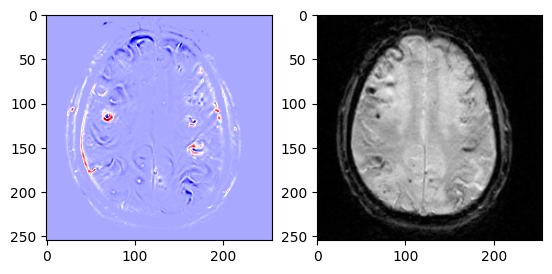

In [20]:
# %%
# Calculate relevances for first image in this test batch
image_id = 2
image_relevances = apply_lrp_on_vgg16(model, inputs[image_id])
image_relevances = image_relevances.permute(0,2,3,1).detach().cpu().numpy()[0]
# Normalize the relevance scores to make them easier to visualize
image_relevances = np.interp(image_relevances, (image_relevances.min(),
                                                image_relevances.max()),
                                                (0, 1))
# Show relevances
pred_label = list(test_dataset.class_to_idx.keys())[
             list(test_dataset.class_to_idx.values())
            .index(labels[image_id])]
if outputs[image_id] == labels[image_id]:
    print("Groundtruth for this image: ", pred_label)

    # Plot images next to each other
    plt.axis('off')
    plt.subplot(1,2,1)
    # Use a color map to distinguish areas of high and low relevance
    plt.imshow(image_relevances[:,:,0], cmap="seismic")
    plt.subplot(1,2,2)
    plt.imshow(inputs[image_id].permute(1,2,0).detach().cpu().numpy())
    plt.show()
else:
    print("This image is not classified correctly.")

# Explainable AI Demos

[Explainable AI Demos](https://lrpserver.hhi.fraunhofer.de/) is an educational or demonstration tool designed to make AI more accessible and understandable to users by visually and interactively showcasing how AI models arrive at their conclusions. There are four different types of demos:

- Handwriting Classification: This demo seems to use LRP to explain how a neural network trained on the MNIST dataset predicts handwritten digits. It suggests that users can input their handwriting for the AI to classify and explain.
- Image Classification: A more advanced LRP demo for image classification that uses a neural network implemented with Caffe, a deep learning framework. This demo likely illustrates how the AI model determines the content of images.
- Text Classification: This is for classifying natural language documents. The neural network provides predictions on the document's semantic category and uses LRP to explain the classification process.
- Visual Question Answering: This demo allows users to ask AI questions about an image and receive not only answers but also visual explanations that highlight relevant parts of the image involved in the AI's reasoning.
<table>
<tr>
    <td style="padding: 10px;"><img src="https://raw.githubusercontent.com/arkeodev/XAI/main/images/lrp_text_recognition_and_classification.png" alt="Text Recognition and Classification" width="600" /></td>
    <td style="padding: 10px;"><img src="https://raw.githubusercontent.com/arkeodev/XAI/main/images/lrp_image_classification.png" alt="Image Classification" width="600" /></td>
</tr>
<tr>
    <td style="padding: 10px;"><img src="https://raw.githubusercontent.com/arkeodev/XAI/main/images/lrp_mnist_image_recognition.png" alt="MNIST Image Recognition" width="600" /></td>
    <td style="padding: 10px;"><img src="https://raw.githubusercontent.com/arkeodev/XAI/main/images/lrp_question_and_answering.png" alt="Question and Answering" width="600" /></td>
</tr>
</table>

# References

- Layer-Wise Relevance Propagation: An Overview (Paper): https://iphome.hhi.de/samek/pdf/MonXAI19.pdf
- Layer-Wise Relevance Propogation: https://www.hhi.fraunhofer.de/en/departments/ai/technologies-and-solutions/layer-wise-relevance-propagation.html
- Explainable AI Demos: https://lrpserver.hhi.fraunhofer.de/
- deepfindr LRP Implementation: https://github.com/deepfindr/xai-series/blob/master/05_lrp.py